# T<sub>1</sub> Variations between Qubits

> 5/3/19

In this document, I'd like to measure T<sub>1</sub> for several different qubits and compare the results. This builds on the earlier notebook `Energy_Relaxation_Measurement.ipynb`, which in turn implements a measurement given in the IBM user guide. While my values for T<sub>1</sub> seem to be off by several orders of magnitude for a single qubit, I suspect that this is simply due to a rather messy conversion from CPU cycles to seconds. However, the relative difference between the T<sub>1</sub> measurements for any two qubits should be preserved, so I can still check my results against the IBM calibration values that way.

In [1]:
# import standard libraries
from collections import Counter  # useful for tallying results
import qiskit as q
import qiskit.tools.monitor as monitor
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

q.IBMQ.load_accounts()

Since this circuit is so similar to that in the previously mentioned notebook, I won't bother documenting it very thoroughly here unless I get particularly good results that I'd like to showcase. That decision will probably come back to bite me at a later date.

In [7]:
qr = q.QuantumRegister(2, 'q')
cr = q.ClassicalRegister(2, 'c')

# preparation stage
prepare = q.QuantumCircuit(qr, cr)
prepare.x(qr)
prepare.barrier()

# measurement stage
measure = q.QuantumCircuit(qr, cr)
measure.barrier()
measure.measure(qr, cr)

# build idle stages
circuits = []
for n in range(25):
    idle = q.QuantumCircuit(qr, cr)
    for _ in range(100 * n):
        idle.iden(qr)
    circuits += [prepare + idle + measure]

We will use 25 runs in increments of 100 gates because the example code of 50 runs in increments of 45 gates produces a "Payload Too Large" error. And again, here is what an example circuit looks like, just for reference:

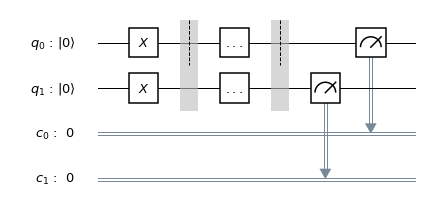

In [3]:
# replace 'id' with '...' for display points
style = {'displaytext': {'id': '...', 'u0': 'U_0', 'u1': 'U_1', 'u2': 'U_2', 'u3': 'U_3', 'x': 'X', 'y': 'Y', 'z': 'Z', 'h': 'H', 's': 'S', 'sdg': 'S^dagger', 't': 'T', 'tdg': 'T^dagger', 'rx': 'R_x', 'ry': 'R_y', 'rz': 'R_z', 'reset': '\left|0rightrangle' }}

idle = q.QuantumCircuit(qr, cr)
idle.iden(qr)
(prepare + idle + measure).draw(output='mpl', style=style)

This time, we will extract the data for both qubits from each trial.

In [4]:
# analyze a trial and return the results as a tuple
def count_results(result, circuits, shots=1024):
    freq1 = []    # frequency of '1' state for each qubit
    freq2 = []
    stderr1 = []  # standard error for each qubit
    stderr2 = []
    
    for c in circuits:
        trial = Counter(result.get_counts(c))
        p1 = (trial['01'] + trial['11']) / shots
        p2 = (trial['10'] + trial['11']) / shots
        freq1 += [p1]
        freq2 += [p2]
        stderr1 += [np.sqrt(p1 * (1 - p1) / shots)]
        stderr2 += [np.sqrt(p2 * (1 - p2) / shots)]
    return freq1, freq2, stderr1, stderr2

Let's try it:

In [8]:
# locate least busy IBM device backend
backends = q.IBMQ.backends(filters=lambda x:
                           x.configuration().n_qubits >= 2
                           and not
                           x.configuration().simulator)
best = q.providers.ibmq.least_busy(backends)

# run the trials on that backend
empty = q.tools.compiler.PassManager()  # disable optimization
job = q.execute(circuits, backend=best, shots=1024,
                max_credits=10, pass_manager=empty)
monitor.job_monitor(job)

# print job info for later retrieval if necessary
print('Job ID \'%s\'' % job.job_id())
print('Ran on backend \'%s\'' % best.name())
print('Completed %s' % job.creation_date())

HTML(value="<p style='font-size:16px;'>Job Status: job is being initialized </p>")

Job ID '5ccc5d39ad9401006e753dd6'
Ran on backend 'ibmqx2'
Completed 2019-05-03T15:24:38.545Z


Now we can retrieve the job and analyze the results:

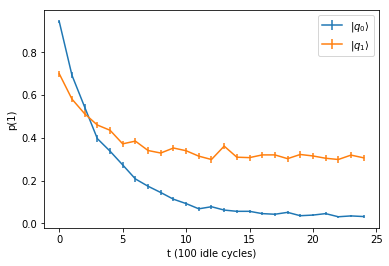

In [43]:
# retrieve job from job_id so that it's easier to re-run later
backend = q.IBMQ.get_backend('ibmqx2')
job = backend.retrieve_job('5ccc5d39ad9401006e753dd6')

# plot experimental results
p1, p2, s1, s2 = count_results(job.result(), circuits)
fig, ax = plt.subplots()
ax.errorbar(range(len(circuits)), p1, s1, label=r'$\vert q_0 \rangle$')
ax.errorbar(range(len(circuits)), p2, s2, label=r'$\vert q_1 \rangle$')
ax.set_xlabel('t (100 idle cycles)')
ax.set_ylabel('p(1)')
ax.legend()

It's a little strange that $\vert q_1 \rangle$ seems to go to 0.3 instead of 0, but at least these curves are much better than we had before. Now we can run some very sophisticated data analysis on the results using `scipy`.

The T1 ratio is 0.876445


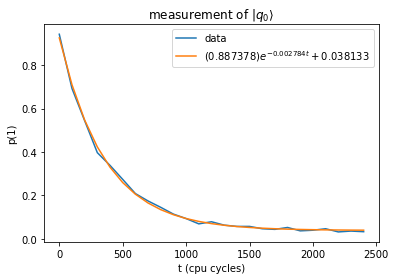

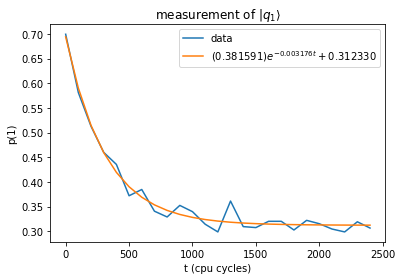

In [40]:
from scipy.optimize import curve_fit

# scale data to cycles from blocks of 100
x = np.array(range(len(circuits))) * 100

# fully parameterized exponential decay model
def model(t, a, b, c):
    return a * np.exp(-b * t) + c

# fit curve for a qubit with scipy
def fit_curve(data, qubit_name):
    a, b, c = curve_fit(model, x, data, p0=[0.5, 0., 0.])[0]
    fig, ax = plt.subplots()
    ax.plot(x, data, label='data')
    ax.plot(x, model(x, a, b, c), label='$(%f)e^{-%f t}+%f$' % (a, b, c))
    ax.set_title(r'measurement of $\vert %s \rangle$' % qubit_name)
    ax.set_xlabel('t (cpu cycles)')
    ax.set_ylabel('p(1)')
    ax.legend()
    return fig, (a, b, c)

fig_1, params_1 = fit_curve(p1, 'q_0')
fig_2, params_2 = fit_curve(p2, 'q_1')
print('The T1 ratio is %f' % (params_1[1] / params_2[1]))

We verify that the code we want is being run by looking at the compiled QASM code:

In [36]:
print(job.qobj().as_dict()['experiments'][0]['header']['compiled_circuit_qasm'])

OPENQASM 2.0;
include "qelib1.inc";
qreg q[2];
creg c[2];
x q[0];
x q[1];
barrier q[0],q[1];
barrier q[0],q[1];
measure q[0] -> c[0];
measure q[1] -> c[1];



We can also check the physical qubit mapping:

In [41]:
job.qobj().as_dict()['experiments'][0]['header']['qubit_labels']

[['q', 0], ['q', 1]]

At the time of writing, the latest calibration values posted on the IBM website are 52.30 μs and 53.50 μs, giving a ratio of 0.9812. We see that our ratio is somewhere in the ballpark of ratios, although not exactly matching the physical qubits we're supposed to be on. Concerningly, our data suggest that $\vert q_1 \rangle$ has a $T_1$ *lower* than $\vert q_0 \rangle$, which is the opposite of what should be going on.

We could try using all five qubits and seeing if it's just a weird thing going on with $\vert q_1 \rangle$, since its curve is a little strange anyway.

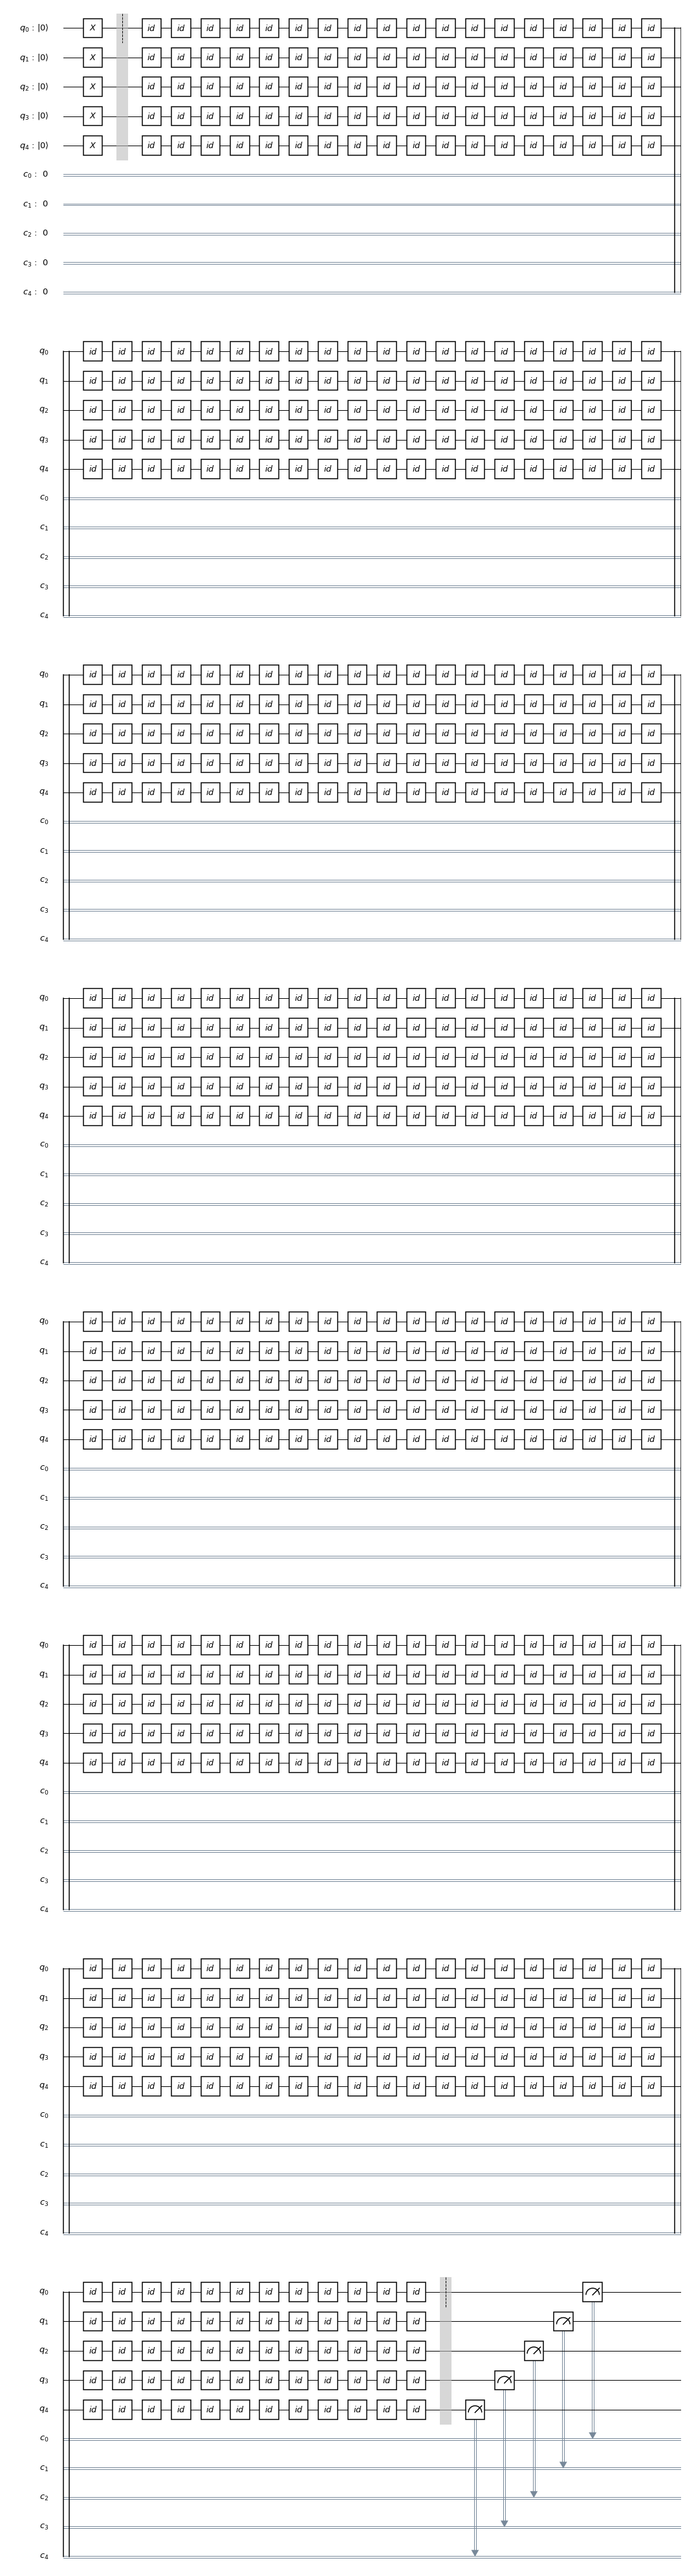

In [54]:
# five-qubit registers
qr5 = q.QuantumRegister(5, 'q')
cr5 = q.ClassicalRegister(5, 'c')

# preparation stage: NOT all the qubits
prepare5 = q.QuantumCircuit(qr5, cr5)
prepare5.x(qr5)
prepare5.barrier()

# measurement stage
measure5 = q.QuantumCircuit(qr5, cr5)
measure5.barrier()
measure5.measure(qr5, cr5)

# build idle stages
circuits5 = []
for n in range(15):
    idle = q.QuantumCircuit(qr5, cr5)
    for _ in range(n * 150):
        idle.iden(qr5)
    circuits5 += [prepare5 + idle + measure5]

circuits5[1].draw(output='mpl')

In [55]:
# locate least busy IBM device backend
backends = q.IBMQ.backends(filters=lambda x:
                           x.configuration().n_qubits >= 5
                           and not
                           x.configuration().simulator)
best5 = q.providers.ibmq.least_busy(backends)

# run the trials on that backend
empty = q.tools.compiler.PassManager()  # disable optimization
job5 = q.execute(circuits5, backend=best5, shots=1024,
                max_credits=10, pass_manager=empty)
monitor.job_monitor(job5)

# print job info for later retrieval if necessary
print('Job ID \'%s\'' % job5.job_id())
print('Ran on backend \'%s\'' % best5.name())
print('Completed %s' % job5.creation_date())

HTML(value="<p style='font-size:16px;'>Job Status: job is being initialized </p>")

Job ID '5ccc74583cb5810074ddedd7'
Ran on backend 'ibmqx2'
Completed 2019-05-03T17:03:19.144Z


In [65]:
# analyze a trial and return the results as a tuple
def count_results5(result, circuits, shots=1024):
    freq   = [[], [], [], [], []]
    stderr = [[], [], [], [], []]
    
    for c in circuits:
        trial = result.get_counts(c)
        for i in range(len(freq)):
            total = 0
            for state, count in trial.items():
                if state[-i-1] == '1':
                    total += count
            freq[i] += [total / shots]
            stderr[i] += [np.sqrt(freq[i][-1] * (1 - freq[i][-1]) / shots)]

    return freq, stderr

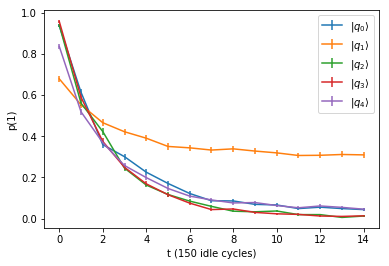

In [73]:
# retrieve job from job_id so that it's easier to re-run later
backend5 = q.IBMQ.get_backend('ibmqx2')
job5 = backend5.retrieve_job('5ccc74583cb5810074ddedd7')

# plot experimental results
def draw_qubit(bit, ax):
    ax.errorbar(range(len(circuits5)), p[bit], s[bit], label=r'$\vert q_%d \rangle$' % bit)

p, s = count_results5(job5.result(), circuits5)
fig5, ax5 = plt.subplots()
for i in range(5):
    draw_qubit(i, ax5)
ax5.set_xlabel('t (150 idle cycles)')
ax5.set_ylabel('p(1)')
ax5.legend()

Aha, it looks like the second qubit is just acting up. We can apply a similar analysis to all the qubits:

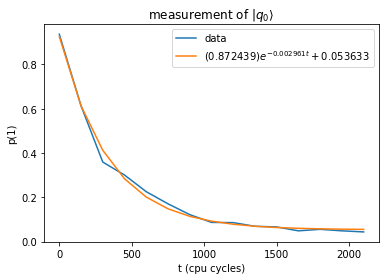

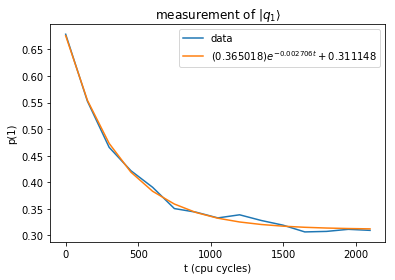

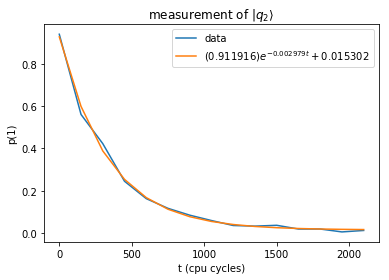

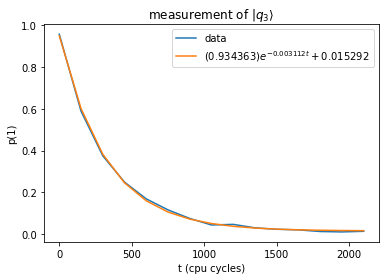

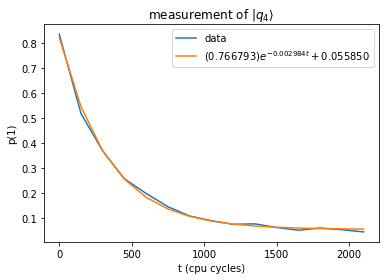

In [72]:
figs = []
params = []

for i in range(5):
    x = np.array(range(len(circuits5))) * 150
    a, b, c = curve_fit(model, x, p[i], p0=[0.5, 0., 0.])[0]
    fig, ax = plt.subplots()
    ax.plot(x, p[i], label='data')
    ax.plot(x, model(x, a, b, c), label='$(%f)e^{-%f t}+%f$' % (a, b, c))
    ax.set_title(r'measurement of $\vert q_%d \rangle$' % i)
    ax.set_xlabel('t (cpu cycles)')
    ax.set_ylabel('p(1)')
    ax.legend()
    figs += [fig]
    params += [(a, b, c)]

And we can find all the ratios here:

In [80]:
for i in range(5):
    for j in range(i + 1, 5):
        e1 = params[i][1]
        e2 = params[j][1]
        print('%d and %d: %f' % (i, j, e1 / e2))

0 and 1: 1.094011
0 and 2: 0.993730
0 and 3: 0.951475
0 and 4: 0.992003
1 and 2: 0.908336
1 and 3: 0.869712
1 and 4: 0.906757
2 and 3: 0.957478
2 and 4: 0.998262
3 and 4: 1.042595


These don't appear to match up exactly to what we expect, but they are definitely in the ballpark.